In [22]:
# imports
from tensorflow import keras
from keras.datasets.mnist import load_data
from keras.layers import Conv2D, Dense, LeakyReLU, ReLU, Input, Reshape, Flatten, BatchNormalization, Conv2DTranspose, Dropout
from keras.models import Model
import numpy as np
from keras.utils import plot_model
from keras.optimizers import Adam

lr_g = 2e-5
lr_d = 5e-5

In [23]:
(X_train,_),(X_test, _) = load_data()
ds_train_size, h, w = X_train.shape
ds_test_size, _, _ = X_test.shape
#
X_train = np.reshape(X_train,(ds_train_size,h,w,1))
X_test = np.reshape(X_test,(ds_test_size,h,w,1))
# normalize datasets
X_train = (X_train / 255.)  # [0,1]
X_train = X_train * 2.      # [0,2]
X_train = X_train - 1.      # [-1,1]

X_test = (X_test / 255.)  # [0,1]
X_test = X_test * 2.      # [0,2]
X_test = X_test - 1.      # [-1,1]


Model: "DC_Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 32)]              0         
_________________________________________________________________
dense_8 (Dense)              (None, 6272)              206976    
_________________________________________________________________
batch_normalization_18 (Batc (None, 6272)              25088     
_________________________________________________________________
re_lu_18 (ReLU)              (None, 6272)              0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 14, 14, 128)       409728    
_________________________________________________________________
batch_normalization_19 (Batc (None, 14, 14, 128)      

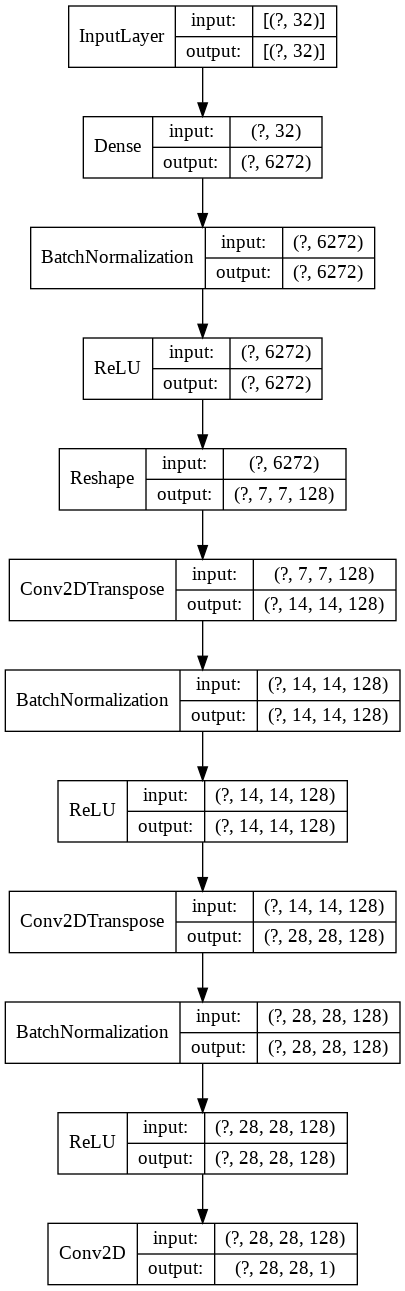

In [24]:
NOISE_DIM = 32
g_input = Input((NOISE_DIM,)) 
x = Dense(128*7*7)(g_input)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Reshape((7,7,128))(x)

x = Conv2DTranspose(128, (5,5), strides=(2,2), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2DTranspose(128, (5,5), strides=(2,2), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

g_output = Conv2D(1, (7,7), activation='tanh', padding='same')(x)

G = Model(g_input, g_output)
G._name = 'DC_Generator'
G.summary()

plot_model(G, to_file='G.png', show_shapes=True, show_layer_names=False)

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 64)        

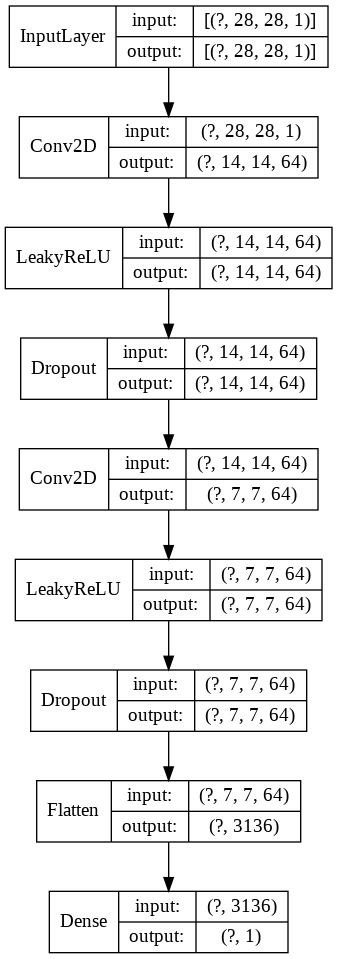

In [25]:
opt = Adam(learning_rate=lr_d)

D_input = Input((h,w,1))

x = Conv2D(64, (3,3), strides=(2, 2), padding='same')(D_input)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.4)(x)

x = Conv2D(64, (3,3), strides=(2, 2), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.4)(x)

x = Flatten()(x)
D_output = Dense(1,activation='sigmoid')(x)

D = Model(D_input, D_output)
D.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])
D._name = 'Discriminator'
D.summary()

plot_model(D, to_file='D.png', show_shapes=True, show_layer_names=False)

In [26]:
opt = Adam(learning_rate=lr_g)
D.trainable = False
G.trainable = True
GAN_input = Input((NOISE_DIM,))
fake = G(GAN_input)
GAN_output = D(fake)

GAN = Model(GAN_input, GAN_output)
GAN._name = 'GAN'
GAN.summary()

plot_model(GAN,to_file='GAN.png', show_layer_names=True, show_shapes=True)

GAN.compile(opt,loss='binary_crossentropy',metrics=['accuracy'])

Model: "GAN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 32)]              0         
_________________________________________________________________
DC_Generator (Functional)    (None, 28, 28, 1)         1058817   
_________________________________________________________________
Discriminator (Functional)   (None, 1)                 40705     
Total params: 1,099,522
Trainable params: 1,045,761
Non-trainable params: 53,761
_________________________________________________________________


In [27]:
import tensorflow as tf
import matplotlib.pyplot as plt

results for epoch 0


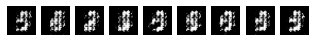

results for epoch 1


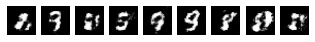

results for epoch 2


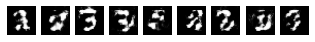

results for epoch 3


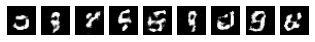

results for epoch 4


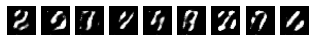

results for epoch 5


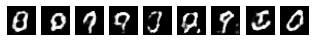

results for epoch 6


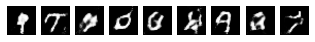

results for epoch 7


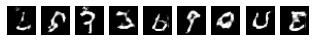

results for epoch 8


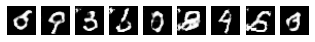

results for epoch 9


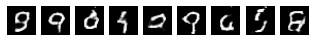

results for epoch 10


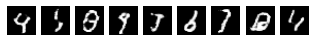

results for epoch 11


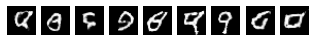

results for epoch 12


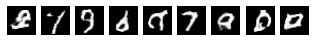

results for epoch 13


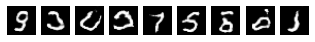

results for epoch 14


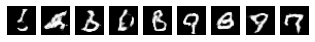

results for epoch 15


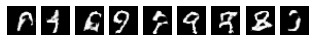

results for epoch 16


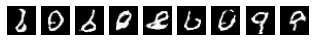

results for epoch 17


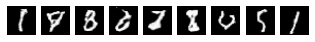

results for epoch 18


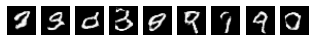

results for epoch 19


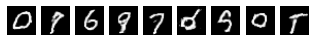

results for epoch 20


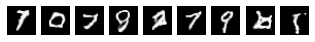

results for epoch 21


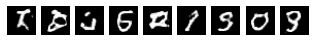

results for epoch 22


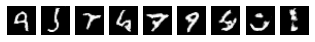

results for epoch 23


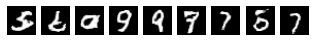

results for epoch 24


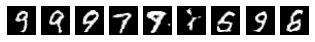

results for epoch 25


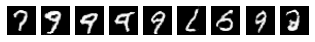

results for epoch 26


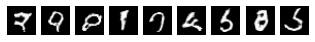

results for epoch 27


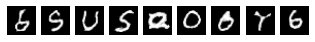

results for epoch 28


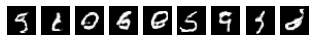

results for epoch 29


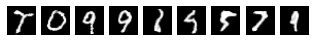

results for epoch 30


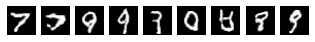

results for epoch 31


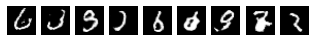

results for epoch 32


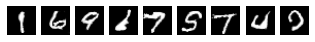

results for epoch 33


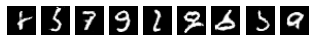

results for epoch 34


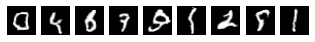

results for epoch 35


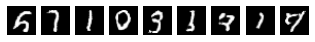

results for epoch 36


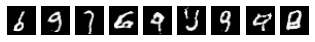

results for epoch 37


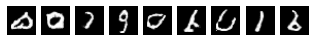

results for epoch 38


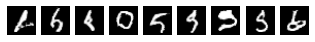

results for epoch 39


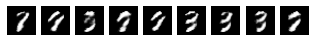

results for epoch 40


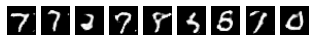

results for epoch 41


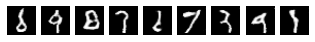

results for epoch 42


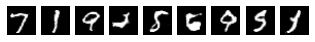

results for epoch 43


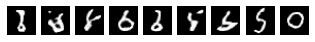

results for epoch 44


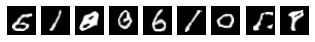

results for epoch 45


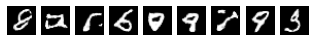

results for epoch 46


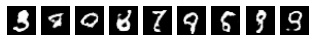

results for epoch 47


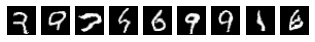

results for epoch 48


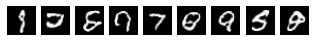

results for epoch 49


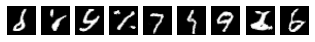

In [28]:
EPOCHS = 50
BATCH_SIZE = 64

np.random.shuffle(X_train)

for epoch in range(EPOCHS):
  for step in range(ds_train_size//BATCH_SIZE):
    # train D on real samples
    idxs = np.random.randint(low=0,high=ds_train_size,size=BATCH_SIZE)
    x_real = X_train[idxs, :]
    D_loss_real, _ = D.train_on_batch(x=x_real,y=np.ones(shape=(BATCH_SIZE)))
    # train D on fake samples
    Z = np.random.randn(BATCH_SIZE, NOISE_DIM,)
    x_fake = G.predict(Z)
    D_loss_fake, _ = D.train_on_batch(x=x_fake,y=np.zeros(shape=(BATCH_SIZE)))
    # train G
    for _ in range(5):
      Z = np.random.randn(BATCH_SIZE, NOISE_DIM)
      G_loss = GAN.train_on_batch(x=Z, y=np.ones(shape=(BATCH_SIZE)))
  # plot samples
  Z = np.random.randn(10, NOISE_DIM,)
  x_fake = G.predict(Z)
  x_fake = np.reshape(x_fake,(10,28,28))
  print(f'results for epoch {epoch}')
  plt.figure()
  for i in range(1,10):
    plt.subplot(1,10,i)
    plt.imshow(x_fake[i,:], cmap='gray')
    plt.axis('off')
  plt.show()

results for epoch 49


<Figure size 432x288 with 0 Axes>

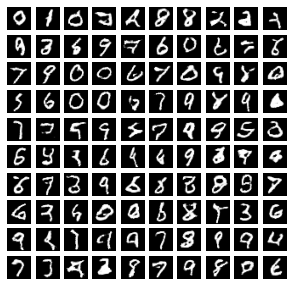

In [31]:
  Z = np.random.randn(101, NOISE_DIM,)
  x_fake = G.predict(Z)
  x_fake = np.reshape(x_fake,(101,28,28))
  print(f'results for epoch {epoch}')
  plt.figure()
  plt.figure(figsize=(5,5))
  for i in range(1,101):
    plt.subplot(10,10,i)
    plt.imshow(x_fake[i-1,:], cmap='gray')
    plt.axis('off')
  plt.show()